In [108]:
#pip install gdown
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score 

from scipy.stats import ttest_ind , f_oneway

In [2]:
path = 'C:/Users/82108/Notebook/PRC_4_data/'

lst = []
for file in os.listdir(path):
   if len(file) == 8 : 
       df = pd.read_csv(f'C:/Users/82108/Notebook/PRC_4_data/{file}')
       lst.append(df)

df = pd.concat(lst).reset_index(drop = True)
df.head()

,연도,신고연도,신고월,신고일,출생자주소지_행정구역시도코드,성별코드,결혼중외의자녀여부코드,출생연도,출생월,출생장소코드,...,다태아분류코드,다태아출산순위코드,출생아체중,모총출생아수코드,모생존아수코드,부모동거기간,부_국적구분코드,부_국적코드,모_국적구분코드,모_국적코드
0,2019,2019,1,1,31,1,Y,2019,1,2,...,1,1,0.453,2,99,999,1,NaN,3,9000.0
1,2019,2019,1,1,33,1,9,2019,1,2,...,9,9,3.090,99,99,999,9,NaN,1,NaN
2,2019,2019,1,2,11,1,Y,2019,1,2,...,1,1,3.380,2,2,4,1,NaN,1,NaN
3,2019,2019,1,2,11,1,Y,2019,1,2,...,1,1,3.060,2,2,4,1,NaN,1,NaN
4,2019,2019,1,2,11,1,Y,2019,1,2,...,2,1,2.645,1,1,1,1,NaN,1,NaN


In [3]:
index = pd.read_csv('C:/Users/82108/Notebook/PRC_4_data/index.csv')
index.head()

,항목명,코드,코드의미 및 단위
0,출생자주소지_행정구역시도코드,11,서울특별시
1,NaN,21,부산광역시
2,NaN,22,대구광역시
3,NaN,23,인천광역시
4,NaN,24,광주광역시


#### ✅ 전처리
1. 년도별 출생 데이터를 하나의 데이터 프레임으로 합친다.
2. 데이터 컬럼 상세 데이터를 바탕으로 출생 데이터의 값을 변환한다.
3. 변환한 데이터 컬럼 중 '미상'을 포함하는 행이 존재한다면 해당 행은 제거한다.
4. 아래의 조건에 해당하는 각 컬럼의 값이 있다면 해당 행은 제거

In [4]:
# 1) 항목명 결측 처리 
index['항목명'] = index['항목명'].fillna(method = 'ffill')

In [5]:
# 2) index dictionary 생성 

# 전체 저장 
dics = {}
for name in index['항목명'].unique() : 
    # 각 항목명 마다 Target 생성 
    target = index[index['항목명'] == name]
    # 항목명에 대한 딕셔너리 저장
    key_value ={}
    for key, value in target.iloc[:,1:].values : 
        # 코드의 앞자리가 0이면 
        if key[0] == '0' : 
            key_value[str(int(key))] = value 
        else : 
            key_value[key] = value 
    dics[name] = key_value

In [6]:
# 3) 데이터 타입 변경 함수
def convert_str(x) : 
    if pd.isna(x) : 
        return np.nan
    elif isinstance(x, str) : 
        return x 
    else : 
        return str(int(x)) 

In [7]:
# 3) df 에 매핑 
for col in df.columns : 
    if col in dics.keys() : 
        # 1) 데이터를 변경하고 
        df[col] = df[col].map(convert_str)
        # 2) Dictionary 와 매핑
        df[col] = df[col].map(dics[col])

In [8]:
df1 = df.copy()
# 변환한 데이터 컬럼 중 '미상'을 포함하는 행이 존재한다면 해당 행은 제거

for col in df1.columns : 
    # [~] 가 아닌것 
    df2 = df1[~ df1[col].astype('str').str.contains('미상')]

In [9]:
remove_dic = {
    '부_교육정도코드' : '학력없음',
    '부_각세연령' : 999.0,
    '모_교육정도코드' : '학력없음',
    '모_각세연령' :999.0,
    '실제결혼연도' : 9999.0,
    '실제결혼월' : 99.0,
    '부모동거기간' : 999,
    '임신주수' : 0
}

for key, value in remove_dic.items() : 
    # Key : Columns 의 값이 value가 아닌것들만 
    df2 = df2[df2[key] != value].reset_index(drop = True)

#### ✅ EDA & 통계 : 출생아체중을 중점

In [13]:
df3 = df2.loc[df2['연도'].isin([2019])]

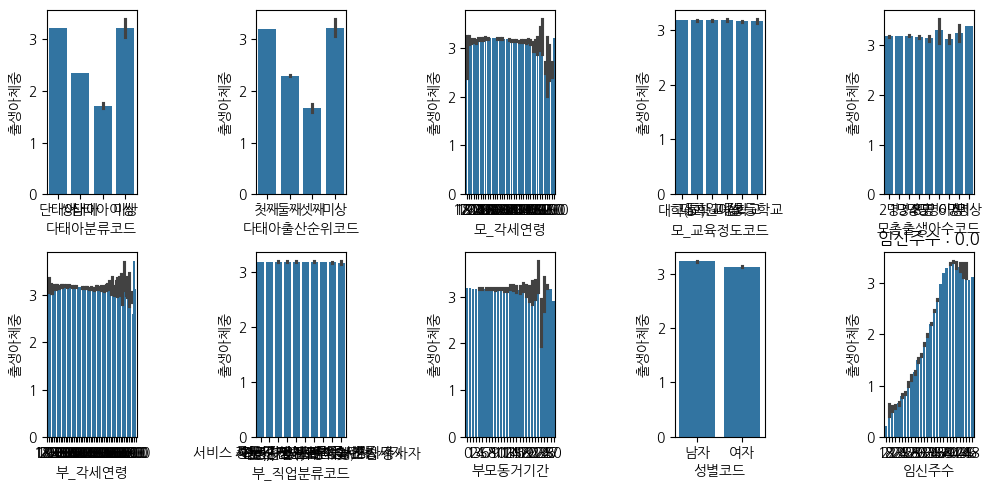

In [18]:
remove_cols = ['연도','신고연도','신고월','신고일', '출생자주소지_행정구역시도코드', 
        '결혼중외의자녀여부코드','부_교육정도코드','모_직업분류코드','출생연도','출생월',
        '출생장소코드','실제결혼연도','실제결혼월','모생존아수코드','부_국적코드','모_국적코드',
        '모_국적구분코드','부_국적구분코드', '출생아체중']
eda_cols = df3.columns.difference(remove_cols)

fig, axes = plt.subplots(5,2, figsize = (10, 5)) 

for i, axes in enumerate(axes.flat[: len(eda_cols)]) : 
    col_i = df3[eda_cols].columns[i]

    lst = []
    if df2[col_i].nunique() == 2 : 
        target = df3[[col_i, '출생아체중']]
        sns.barplot(x = target[col_i], y = target['출생아체중'], ax = axes)
        
        # Unique 한 값들을 추출 
        values = df3[col_i].unique()
        g1 = df3[df3[col_i] == values[0]]['출생아체중']
        g2 = df3[df3[col_i] == values[1]]['출생아체중']

        stat, p_val = ttest_ind(g1, g2)
        
    elif df3[col_i].nunique() >= 3 : 
        target = df3[[col_i, '출생아체중']]
        sns.barplot(x = target[col_i], y = target['출생아체중'], ax = axes)

        groups = df3[col_i].unique()
        group_data = [df3[df3[col_i] == val]['출생아체중'] for val in groups]

        stat, p_val = f_oneway(*group_data)

    lst.append([col_i, p_val])

plt.tight_layout()
plt.title(f'{col_i} : {p_val}')
plt.show()

#### ✅ Modeling 
    1) 신고월이 2월이며 신고일이 10일 이하
    2) 출생아 체중을 예측하는 회귀 모델 
      * 성별코드 기준으로 층화추출 진행 (학습데이터 70%, 평가 데이터 30%)
      * 평가기준 rmse
      * 랜덤포레스트, 다중선형회귀 모델로 진행

In [27]:
cols = ['연도','신고연도','신고월','신고일', '출생자주소지_행정구역시도코드', 
        '결혼중외의자녀여부코드','부_교육정도코드','모_직업분류코드','출생연도','출생월',
        '출생장소코드','실제결혼연도','실제결혼월','모생존아수코드','부_국적코드','모_국적코드',
        '모_국적구분코드','부_국적구분코드']

m_df = df2[(df2['신고월'] == 2 )& (df2['신고일'] <= 10)].reset_index(drop = True)
m_df = m_df.drop(columns = cols, axis = 1)
m_df.head()

,성별코드,부_직업분류코드,부_각세연령,모_교육정도코드,모_각세연령,임신주수,다태아분류코드,다태아출산순위코드,출생아체중,모총출생아수코드,부모동거기간
0,남자,관리자,31.0,대학원이상,31.0,40,단태아,첫째,3.180,1명,0
1,남자,관리자,33.0,대학(교),42.0,38,단태아,첫째,3.340,1명,1
2,남자,관리자,30.0,대학(교),30.0,38,단태아,첫째,3.930,1명,1
3,남자,관리자,33.0,대학(교),32.0,38,단태아,첫째,3.114,2명,4
4,남자,관리자,33.0,대학(교),33.0,38,단태아,첫째,3.790,1명,0


In [56]:
# 1) 연속형 
num_cols = m_df.select_dtypes(exclude = 'object').columns.difference(['출생아체중']) 
num_df = m_df[num_cols]

ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(num_df), columns = num_df.columns)

# 2) 범주형 
from sklearn.preprocessing import LabelEncoder

cate_cols = m_df.select_dtypes(include = 'object').columns
cate_df = m_df[cate_cols]

for col in cate_df.columns :
    la = LabelEncoder()
    cate_df[col] = la.fit_transform(cate_df[col])

In [61]:
# 3) 최종 
X = pd.concat([num_df, cate_df], axis = 1)
y = m_df['출생아체중']

In [64]:
# 성별코드 기준으로 층화추출 진행 (학습데이터 70%, 평가 데이터 30%) - Label Encoder
# 평가기준 rmse
# 랜덤포레스트, 다중선형회귀 모델로 진행

def eval_model (name, model) : 
    x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = 0.3 , stratify= X['성별코드'] , random_state = 52)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mse = np.sqrt(mean_squared_error(y_test, pred))

    return mse 


res = []
for name, model  in [['LR', LinearRegression()], ['RF', RandomForestRegressor()]] : 
    mse = eval_model(name, model)
    res.append([name, mse])

model_result = pd.DataFrame(res, columns = ['Model' ,'MSE'])
model_result

,Model,MSE
0,LR,0.358294
1,RF,0.369151


#### 🧪 서울시 지하철 데이터
#####  ✅ 전처리 

In [77]:
df = pd.read_csv('C:/Users/82108/Notebook/PRC_4_data/subway.csv')
df.head()

,날짜,역번호,역명,구분,05~06,06~07,07~08,08~09,09~10,10~11,...,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,호선
0,2016-01-01,150,서울역(150),승차,469,339,584,1144,1723,2087,...,3554,3200,3076,2519,2281,2398,2056,996,58,1
1,2016-01-01,150,서울역(150),하차,342,1637,1753,1856,2438,2425,...,3108,2656,2134,1859,1394,1344,1056,612,222,1
2,2016-01-01,151,시청(151),승차,103,127,110,191,298,582,...,1339,1458,1499,1383,1284,1198,675,375,9,1
3,2016-01-01,151,시청(151),하차,68,306,554,939,689,665,...,1035,951,792,618,402,309,192,114,34,1
4,2016-01-01,152,종각(152),승차,702,341,234,296,335,419,...,2175,2580,2627,2302,2315,2365,2140,1117,51,1


In [82]:
melt_df = df.drop(columns = ['역명'], axis = 1).reset_index(drop = True).\
             melt(id_vars = ['날짜','역번호', '호선','구분'] , var_name = '시간' , value_name = '인원수'  )
melt_df.head(4)

,날짜,역번호,호선,구분,시간,인원수
0,2016-01-01,150,1,승차,05~06,469
1,2016-01-01,150,1,하차,05~06,342
2,2016-01-01,151,1,승차,05~06,103
3,2016-01-01,151,1,하차,05~06,68


In [89]:
pivot_df = melt_df.pivot_table(index = ['날짜', '호선', '시간'] , columns = '구분' , values = '인원수').reset_index()
pivot_df['ratio'] = pivot_df['승차'] / pivot_df['하차']


p_df = pivot_df.pivot_table(index = ['날짜','호선'], columns = '시간', values = 'ratio').reset_index()
p_df.head(3)

시간,날짜,호선,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,...,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~
0,2016-01-01,1,3.569672,0.631725,0.548638,0.636792,0.775704,0.808009,0.831517,0.770004,...,1.045816,1.277316,1.353502,1.395663,1.458895,1.772087,1.944890,1.846209,1.311940,0.183721
1,2016-01-01,2,5.173876,1.198138,1.191171,1.100397,0.981767,1.037915,0.989607,0.968656,...,0.930663,0.979071,0.966366,0.934122,0.958119,1.079435,1.189924,1.170612,0.760431,0.004000
2,2016-01-01,3,3.814969,0.630485,0.782427,0.833200,0.759934,0.787604,0.828105,0.863113,...,1.018443,1.102005,1.154037,1.070333,1.050004,1.114768,1.227530,1.097164,0.506338,0.011957


In [97]:
# 주말 여부 - weekday
p_df['날짜'] = pd.to_datetime(p_df['날짜'])
p_df['weekday'] = p_df['날짜'].apply(lambda x : 1  if x.weekday() >= 5 else 0).astype(int)

##### ✅ Modeling (호선 예측) - 다중 분류기
    1) 평가데이터 : 일(day)이 4로 나눈 나머지가 1인 일자 / 학습데이터 : 그 외
    2) 평가지표 : f1_score (micro,macro 모두 확인) AND 2가지 이상 모델

In [106]:
train_set = p_df[p_df['날짜'].dt.day % 4 == 1].drop(columns = ['날짜'], axis = 1).reset_index(drop = True)
test_set = p_df[p_df['날짜'].dt.day % 4 != 1].drop(columns = ['날짜'], axis = 1).reset_index(drop = True)

x_train = train_set.drop(columns = ['호선'], axis = 1)
y_train = train_set['호선']

x_test = test_set.drop(columns = ['호선'], axis = 1)
y_test = test_set['호선']

#### 🎯 모델 차이
1) 랜덤 포레스트
   - 과적합 방지: 여러 나무의 평균을 사용해 과적합 위험을 줄임.
   - 특징 중요도 제공: 어떤 피처(예: 역 이름, 시간대 등)가 분류에 중요한지 분석 가능.
   - 데이터 전처리 덜 민감: 결측치나 이상치에 비교적 강건함.
   - 병렬 처리 가능: 대규모 데이터셋에서도 효율적.
2) 서포트 벡터 머신 (SVM) </br>
클래스 간 최대 마진을 찾는 초평면을 기반으로 분류하며, 커널 트릭을 통해 비선형 데이터도 처리 가능.
    - 비선형 분류 우수: RBF 커널 등을 사용하면 복잡한 패턴의 호선 분류에 효과적.
    - 소규모 데이터에 강력: 지하철 호선 데이터가 비교적 작거나 중간 규모일 때 안정적.
    - 이상치에 강건: 마진 최대화 원리로 이상치 영향을 최소화.

#### 🎯  Micro vs Macro 비교
| 항목              | Micro F1-Score                          | Macro F1-Score                          |
|-------------------|-----------------------------------------|-----------------------------------------|
| **가중치**        | 샘플 수에 따라 가중(대규모 클래스 영향↑) | 클래스별 동일 가중(소수 클래스 영향↑)   |
| **클래스 불균형** | 불균형에 민감(다수 클래스 중심)         | 불균형에 덜 민감(모든 클래스 균등)      |
| **해석**          | 전체적인 예측 성능 강조                 | 클래스별 고른 성능 강조                 |
| **적합 상황**     | 전체 정확도가 중요한 경우               | 소수 클래스 성능이 중요한 경우           |

#### 🎯 왜 둘 다 보나?
- **Micro**: 전체 호선 예측 정확도(실제 적용 성능) 평가. 예: 1호선이 데이터 80% 차지 시 1호선 성능에 좌우.
- **Macro**: 소수 호선 성능 저하 감지, 공정성과 일반화 확인.
- **종합 판단**: Micro로 전체 성능, Macro로 클래스별 균형 확인해 모델 개선.

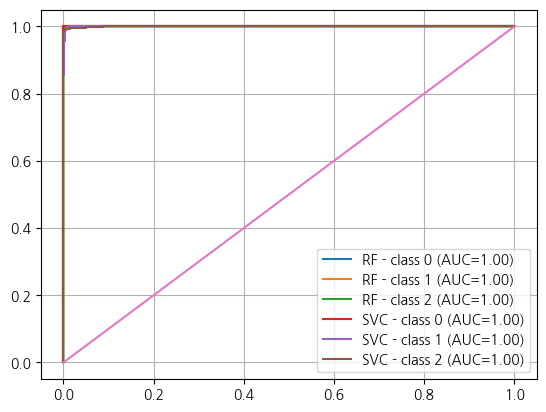

  Model_Name  F1_micro  F1_macro
0         RF  0.997531  0.997531
1        SVC  0.993210  0.993209


In [119]:
from sklearn.preprocessing import label_binarize

def eval_modle(name, model, x_train, y_train, x_test, y_test) : 
    model.fit(x_train, y_train) 
    pred = model.predict(x_test)
    f1_micro = f1_score(y_test, pred, average = 'micro')
    f1_macro = f1_score(y_test, pred, average = 'macro')
    
    pred_prob = model.predict_proba(x_test)
    auc = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')

    # ROC Curve (per class) - 다중일떄는 Class 별 커브 
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    for i in range(pred_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y_bin[:, i], pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{name} - class {i} (AUC={auc:.2f})')

    return f1_micro, f1_macro

res = []
# SVM : 다중 분류일때 probability= True 로 설정하기 
for name, model in [['RF', RandomForestClassifier()] , ['SVC', SVC(probability= True)]] : 
    f1_micro, f1_macro = eval_modle(name, model, x_train, y_train, x_test, y_test) 
    res.append([name, f1_micro, f1_macro])

plt.plot([0,1],[0,1])
plt.grid(True)
plt.legend()
plt.show()

print(pd.DataFrame(res, columns = ['Model_Name','F1_micro' , 'F1_macro']))

#### 🔍 통계 
✅ 1. 
한 카페에서는 고객들이 음료를 주문한 후, 음료가 준비되는 시간을 추적한다. 음료 준비 시간은 평균이 5분이고, 표준편차가 1.5분인 정규분포
1) 특정 고객이 음료를 6분 이내에 받을 확률은?
2) 3분에서 7분 사이에 음료가 준비될 확률은?
3) 10명의 고객 중, 6분 이내에 음료를 받을 고객이 3명 이상일 확률은?

In [131]:
import scipy.stats as stats
from scipy.stats import binom
x = 5 
std = 1.5 

rv = stats.norm(x, std)

# 1) 6분 이내
minute6 = rv.cdf(6)
print(rv.cdf(6))

#2) 3분 7분 사이 
print(rv.cdf(7) - rv.cdf(3))

#3) 10명 중 6분 이내에 고객이 3명 이상 - 위에서의 6분 이내(p)로 계산해서 binom
n = 10 
rv = binom( n, minute6 )
print(1 - rv.cdf(2))

0.7475074624530771
0.8175775605482642
0.999552401593017


✅ 2. A, B 고객 요리에 대만 만족도 

In [133]:
# 셰프 A와 셰프 B의 고객 점수
A = np.array([7, 8, 9, 5, 6, 7, 8, 6, 7, 9])
B = np.array([6, 5, 8, 7, 6, 5, 6, 4, 7, 5])

from scipy.stats import wilcoxon   #대응 표본(paired data, 예: 같은 역의 아침 vs 저녁 혼잡도) 비교
stat, p_val = wilcoxon(A, B)
print(p_val)

0.0625


✅ 3. 
- 전체 인구에서 질병을 가진 사람의 비율: 2%
- 질병이 없는 사람의 비율: 98%
- 질병이 있는 경우 검사 X가 양성일 확률: 73%
- 질병이 없는 경우 검사 X가 양성일 확률: 10%
- 질병이 있는 경우 검사 Y가 양성일 확률: 66%
- 질병이 없는 경우 검사 Y가 양성일 확률: 5%
1) 검사 X와 검사 Y 모두 양성일 때, 환자가 실제로 질병을 가질 확률은 얼마인가?
2) 검사 X가 양성이고 검사 Y가 음성일 때, 환자가 실제로 질병을 가질 확률은 얼마인가?
3) 검사 Y가 양성일 때, 검사 X가 음성일 확률은?

In [138]:
d_positive = 0.02 
d_negative = 0.98 

p_x_positive = 0.73 
no_p_x_positive = 0.1

p_y_positive = 0.66 
no_p_y_positive = 0.05 

In [140]:
# 1) 검사 X와 검사 Y 모두 양성일 때, 환자가 실제로 질병을 가질 확률은
# 0.73 * 0.66 : 모두 질병이 있을때 양성인 경우의 곱 
y_disease_positive = p_x_positive * p_y_positive 

# 0.1 * 0.05 : 질병이 없었을 때 양성인 경우의 곱 
n_disease_positive = no_p_x_positive * no_p_y_positive

# 질병양성 * 질병 0.02 + 질병없는데 양성 * 0.98
xy_positive = y_disease_positive * d_positive + n_disease_positive * d_negative

# 모두 질병이 있을때 * 질병 확률 /전체 양성
given_positive = (y_disease_positive * d_positive) / xy_positive
print(given_positive)

0.662905888827738


In [141]:
# 2) 검사 X가 양성이고 검사 Y가 음성일 때, 환자가 실제로 질병을 가질 확률

# 1) 질병이 있을때 
# P(X: 양성 | Y : 음성) 
yd_x_p_y_n = 0.73 * (1 - 0.66)

# 2) 질병 없을 때 
yn_x_p_y_n = 0.1 * (1- 0.05)

# 3) 
p = (yd_x_p_y_n * 0.02) + (yn_x_p_y_n * 0.98)

# 4) 
res = (yd_x_p_y_n * 0.02 )/ p
print(res)

0.05062000326317507


In [143]:
# 3) 검사 Y가 양성일 때, 검사 X가 음성일 확률은?

# 1) 질병 있을때 
yd_x_p_y_n = 0.66 * ( 1- 0.73)

# 2) 질병 없을 때 
yn_x_p_y_n = 0.05 * (1 - 0.1)

# 3) 전체 
p = (yd_x_p_y_n * 0.02) + (yn_x_p_y_n * 0.98)

# 4) 질병이 있을때, 없을때의 Y 전체 
y_p = (0.66 * 0.02) + (0.05 * 0.98)


p / y_p

0.7663022508038585